In [350]:
import numpy as np
from scipy.integrate import odeint
import copy as cp
import matplotlib.pylab as plt
from numpy.random import poisson
import pandas as pd

In [351]:
class Config:
    def __init__(self, params):
        params = cp.deepcopy(params)
        self.__dict__["_params"] = params
        for k, v in params.items():
            self.__dict__[k] = v

    def __getitem__(self, key):
        return self._params[key]

    def __setitem__(self, key, value):
        self.__setattr__(key, value)

    def __setattr__(self, key, value):
        self._params[key] = value
        self.__dict__[key] = value

    def clone_me(self):
        return Config(self._params)

    def update(self, kwargs):
        return Config({**self._params, **kwargs})

    def _repr_html_(self):
        return pd.Series(self._params).to_frame().T._repr_html_()

    def getkeys(self):
        return list(self._params.keys())

In [352]:
def system(pop, t, cg):
    F, A, H = pop
    dFdt = cg.rho * F + cg.tau * A - cg.alpha * F*F - cg.mu*F - cg.beta * F * H
    dAdt = cg.r * cg.p * A + cg.beta * F * H - cg.gamma * (A + H) * A - (cg.d + cg.nu) * A
    dHdt = cg.r * H + cg.r * (1 - cg.p) * A - cg.gamma * (A + H) * H - cg.d * H - cg.beta * F * H
    return [dFdt, dAdt, dHdt]

In [353]:
def sys_birth(pop, cg, V):
    F, A, H = pop/V
    bF = cg.rho * F + cg.tau * A
    bA = cg.r * cg.p * A + cg.beta * F * H
    bH = cg.r * H + cg.r * (1 - cg.p) * A
    return np.array([bF, bA, bH])

def sys_death(pop, cg, V):
    F, A, H = pop/V
    dF = cg.alpha * F*F + cg.mu*F + cg.beta * F * H
    dA = cg.gamma * (A + H) * A + (cg.d + cg.nu) * A
    dH = cg.gamma * (A + H) * H + cg.d * H + cg.beta * F * H
    return np.array([dF, dA, dH])

def tau_leap(init, birth_rate, death_rate, Tmax, dt, cg, V):
    state = [init]
    time = [0]
    tseries = np.arange(0, Tmax - 1, 1)
    for i in tseries:
        br = birth_rate(init, cg, V)
        bn = np.random.poisson(init * np.exp(br * dt))
        dr = death_rate(init, cg, V)
        dn = np.random.poisson(init * np.exp(dr * dt))
        init = init + bn - dn
        if all(init > 0):
            state.append(init)
            time.append(i + 1)
        else:
            break
    return dict(t = time, x = np.array(state))

In [484]:
def tau(rho, nu, cg):
    assert isinstance(rho, np.ndarray), "mutant rho has to be a numpy array"
    assert isinstance(nu, np.ndarray), "mutant nu value has to be a numpy array"
    return cg.theta - cg.v * rho**cg.h + (cg.eta * nu * (nu + cg.d)**cg.g)/cg.nu_max

def F_birth_mut(pop_F, pop_A, cg, V, rho_mut, nu_mut):
    assert isinstance(rho_mut, np.ndarray), "mutant rho has to be a numpy array"
    assert isinstance(nu_mut, np.ndarray), "mutant nu value has to be a numpy array"
    assert isinstance(pop_F, np.ndarray), "F population has to be a numpy array"
    assert isinstance(pop_A, np.ndarray), "A population has to be a numpy array"
    return rho_mut * pop_F/V + tau(rho_mut, nu_mut, cg) * pop_A/V

def A_birth_mut(pop_F, pop_A, pop_H, cg, V):
    assert isinstance(pop_F, np.ndarray), "F population has to be a numpy array"
    assert isinstance(pop_A, np.ndarray), "A population has to be a numpy array"
    return cg.r * cg.p * pop_A/V + cg.beta * (pop_F/V) * (pop_H/V)

def H_birth_mut(pop_A, pop_H, cg, V):
    assert isinstance(pop_A, np.ndarray), "A population has to be a numpy array"
    assert len(pop_H) == 1, "There is always one host population"
    return cg.r * pop_H/V + cg.r * (1 - cg.p) * pop_A.sum()/V


def F_death_mut(pop_F, pop_H, cg, V):
    assert isinstance(pop_F, np.ndarray), "F population has to be a numpy array"
    return cg.alpha * (pop_F/V) * (pop_F.sum())/V + cg.mu * pop_F/V + cg.beta * (pop_F/V) * (pop_H/V)


def A_death_mut(pop_F, pop_A, pop_H, cg, V, nu_mut):
    assert isinstance(nu_mut, np.ndarray), "mutant nu value has to be a numpy array"
    assert isinstance(pop_F, np.ndarray), "F population has to be a numpy array"
    assert isinstance(pop_A, np.ndarray), "A population has to be a numpy array"
    return cg.gamma * ((pop_A.sum() + pop_H)/V) * pop_A/V + (cg.d + nu_mut) * pop_A/V

def H_death_mut(pop_F, pop_A, pop_H, cg, V):
    assert isinstance(pop_F, np.ndarray), "F population has to be a numpy array"
    assert isinstance(pop_A, np.ndarray), "A population has to be a numpy array"
    assert len(pop_H) == 1, "There is always one host population"
    return cg.gamma * ((pop_A.sum() + pop_H)/V) * pop_H/V + cg.d * pop_H/V + cg.beta * (pop_F.sum()/V) * (pop_H/V)

def tau_leap_symbiosis_mutation(pop_init, Tmax, dt, cg, V, trait_init, sigma_rho, sigma_nu, mutant_rate):
    F_state = [pop_init[0:1]]
    A_state = [pop_init[1:2]]
    H_state = [pop_init[2:3]]
    rho_val = [trait_init[0:1]]
    nu_val = [trait_init[1:2]]
    tau_val = [tau(trait_init[0:1], trait_init[1:2], cg)]
    time = [0]
    for i in range(Tmax):
        if any(F_state[i] > 0) and any(H_state[i] > 0):
            # if any population number is negative, set it to zero
            F_state[i] = np.where(F_state[i] > 0, F_state[i], 0)
            A_state[i] = np.where(A_state[i] > 0, A_state[i], 0)
            H_state[i] = np.where(H_state[i] > 0, H_state[i], 0)
            br = A_birth_mut(F_state[i], A_state[i], H_state[i], cg, V) # rate
            dr = A_death_mut(F_state[i], A_state[i], H_state[i], cg, V, nu_val[i]) # rate
            A_change = poisson(A_state[i] * np.exp(br * dt)) - poisson(A_state[i] * np.exp(dr * dt)) # intergers
            br = H_birth_mut(A_state[i], H_state[i], cg, V) # rate
            dr = H_death_mut(F_state[i], A_state[i], H_state[i], cg, V) # rate
            H_change = poisson(H_state[i] * np.exp(br * dt)) - poisson(H_state[i] * np.exp(dr * dt)) # intergers

            br = F_birth_mut(F_state[i], A_state[i], cg, V, rho_val[i], nu_val[i]) # rate
            dr = F_death_mut(F_state[i], H_state[i], cg, V) # rate
            F_change = poisson(F_state[i] * np.exp(br * dt)) - poisson(F_state[i] * np.exp(dr * dt)) # intergers
            # Number of mutants arise with each parent
            new_mut_arise = np.random.binomial(F_change * (F_change > 0), mutant_rate)
            ismutate = new_mut_arise > 0
            # arised mutants with corresponding parents' value
            rh = np.random.normal(rho_val[i], sigma_rho) * ismutate
            nn = np.random.normal(nu_val[i], sigma_nu) * ismutate
            tt = tau(rh, nn, cg)
            # Only keep the trait values if they are within range
            nn_cond = (-cg.d <= nn) * (nn <= cg.nu_max)
            tt_cond = tt >= 0
            mut_cond = nn_cond * tt_cond # final conditions are the combination of conditions for both nu and rho
            rh = rh * mut_cond
            nn = nn * mut_cond
            tt = tt * mut_cond
            # Even if new mutants arise, if the traits is not within range, it does not count
            new_mut_arise = new_mut_arise * mut_cond
            # Change in F population after mutation
            F_change_after_mut = F_change - new_mut_arise
            if any(ismutate * mut_cond):
                new_mut_nb = new_mut_arise[new_mut_arise > 0]
                new_rho = rh[rh != 0]
                new_nu = nn[nn != 0] 
                new_tau = tau(new_rho, new_nu, cg)
                A_new = np.zeros(len(new_mut_nb))
            else:
                new_mut_nb, A_new = (), ()
                new_rho, new_nu, new_tau = (), (), ()          
            # Update values on next time step
            A_state.append(np.concatenate((A_state[i] + A_change, A_new), axis = None))
            H_state.append(H_state[i] + H_change)
            F_state.append(np.concatenate((F_state[i] + F_change_after_mut, new_mut_nb), axis = None))
            rho_val.append(np.concatenate((rho_val[i], new_rho), axis = None))
            nu_val.append(np.concatenate((nu_val[i], new_nu), axis = None))
            tau_val.append(np.concatenate((tau_val[i], new_tau), axis = None))
            time.append(i + 1)
        else:
            break
    return dict(t = time, x_F = F_state, x_A = A_state, x_H = H_state, rho = rho_val, nu = nu_val, tau = tau_val)

def turn_raw_dat_to_arrays(dat):
    xF_arr, xA_arr = [], []
    r_arr, n_arr, t_arr = [], [], []
    x_F, x_A = dat["x_F"], dat["x_A"]
    rho, nu, tau = dat["rho"], dat["nu"], dat["tau"]
    assert (len(x_F[-1]) == len(x_A[-1]) == len(rho[-1]) == len(nu[-1]) == len(tau[-1]))
    tt = len(x_F[-1])
    Tmax = dat["t"][-1]
    for i in range(Tmax):
        assert (len(x_F[i]) == len(x_A[i]) == len(rho[i]) == len(nu[i]) == len(tau[i]))
        cc = tt - len(x_F[i])
        xx = np.concatenate((x_F[i], np.zeros(cc)))
        xF_arr.append(xx)
        xx = np.concatenate((x_A[i], np.zeros(cc)))
        xA_arr.append(xx)
        xx = np.concatenate((rho[i], np.zeros(cc)))
        r_arr.append(xx)
        xx = np.concatenate((nu[i], np.zeros(cc)))
        n_arr.append(xx)
        xx = np.concatenate((tau[i], np.zeros(cc)))
        t_arr.append(xx)
    r_mesh = np.tile(rho[-1], (Tmax, 1))
    n_mesh = np.tile(nu[-1], (Tmax, 1)) 
    t_mesh = np.tile(tau[-1], (Tmax, 1))
    time_mesh =  np.tile(dat["t"][:-1], (tt, 1))
    return dict(t = dat["t"], x_F = np.array(xF_arr), x_A = np.array(xA_arr), x_H = dat["x_H"], 
                rho = np.array(r_arr), nu = np.array(n_arr), tau = np.array(t_arr),
                rho_mesh = r_mesh, nu_mesh = n_mesh, tau_mesh = t_mesh, time_mesh = time_mesh.T)

In [485]:
cg_eco = Config(dict(mu = 1.4, alpha = 1.2, gamma = 1.23, p = 0.1, beta = 2.1, 
                     r = 2.3, d = 1.3, rho = 3.6, tau = 1.1008, nu = -0.2))
init = np.array([0.1, 1., 0.2])
tseries = np.linspace(0, 50, 200)

array([1.56235355, 0.56853875, 0.34559794])

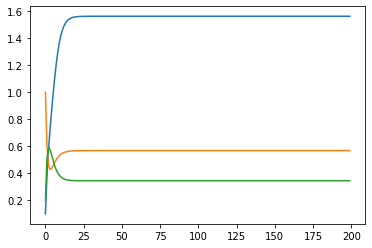

In [486]:
dyn = odeint(system, init, tseries, args=(cg_eco,))
plt.plot(dyn)
dyn[-1,]

()

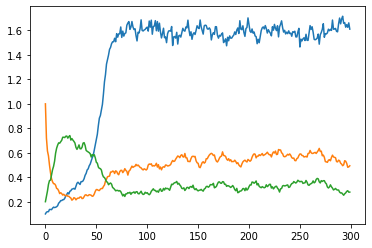

In [487]:
np.random.seed(1)
V = 5000
xx = tau_leap(init * V, sys_birth, sys_death, 300, 0.1, cg_eco, V)
plt.plot(xx['x']/V)
np.shape(xx)

In [488]:
cg_evo =  Config(dict(eta = 1., g = 0.312, mu = 1.4, alpha = 1.2, gamma = 1.23, p = 0.1, beta = 2.1, 
                      r = 2.3, d = 1.3, theta = 8., v = 1., h = 1.5, nu_max = 3))

In [489]:
tau(np.array([3.6]), np.array([-0.2]), cg_evo)

array([1.10080137])

In [490]:
np.random.seed(1)
V = 5000
dyn_stoc = tau_leap_symbiosis_mutation(pop_init = init * V, Tmax = 200, dt = 0.1, cg = cg_evo, V = V, 
                                       trait_init = np.array([3.6, -0.2]), sigma_rho = 0.5, sigma_nu = 0.3, 
                                       mutant_rate = 0)

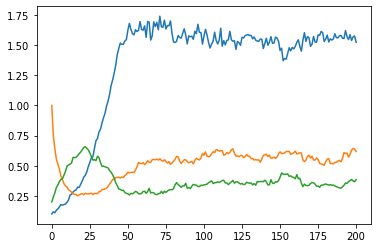

In [491]:
plt.plot(np.array(dyn_stoc["x_F"])/V)
plt.plot(np.array(dyn_stoc["x_A"])/V)
plt.plot(np.array(dyn_stoc["x_H"])/V)

In [492]:
cg_evo_1 =  Config(dict(eta = 1., g = 0.312, mu = 1.4, alpha = 1.2, gamma = 1.23, p = 0.1, beta = 2.1,
                        r = 2.3, d = 1.3, theta = 8., v = 1., h = 1.5, nu_max = 3))

In [513]:
np.random.seed(1)
V = 5000
dyn_stoc_1 = tau_leap_symbiosis_mutation(pop_init = init * V, Tmax = 200, dt = 0.1, cg = cg_evo, V = V, 
                                         trait_init = np.array([3.6, -0.2]), sigma_rho = 0.5, sigma_nu = 0.1, 
                                         mutant_rate = 0.0001)

In [514]:
dyn_stoc_arr_1 = turn_raw_dat_to_arrays(dyn_stoc_1)

In [515]:
dyn_stoc_arr_1["rho_mesh"].shape, dyn_stoc_arr_1["time_mesh"].shape, dyn_stoc_arr_1["x_A"].shape

((200, 3), (200, 3), (200, 3))

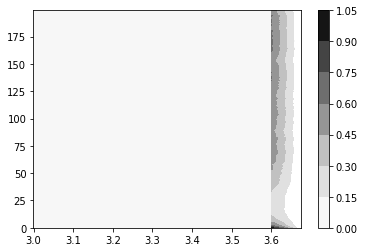

In [516]:
plt.contourf(dyn_stoc_arr_1["rho_mesh"], dyn_stoc_arr_1["time_mesh"], 
             dyn_stoc_arr_1["x_A"]/V, cmap = "Greys")
plt.colorbar()